In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
final_df = pd.read_csv("/Users/yuvraj/portfolio project_win/portfolio project/Dataset/Final.csv")

In [3]:
final_df.head()

,teacher_number_of_previously_posted_projects,project_is_approved,quantity,price,project_title_art,project_title_book,project_title_books,project_title_building,project_title_class,project_title_classroom,...,"project_subject_categories_Music & The Arts, Applied Learning","project_subject_categories_Music & The Arts, Health & Sports","project_subject_categories_Music & The Arts, History & Civics","project_subject_categories_Music & The Arts, Special Needs","project_subject_categories_Music & The Arts, Warmth, Care & Hunger",project_subject_categories_Special Needs,"project_subject_categories_Special Needs, Health & Sports","project_subject_categories_Special Needs, Music & The Arts","project_subject_categories_Special Needs, Warmth, Care & Hunger","project_subject_categories_Warmth, Care & Hunger"
0,0,0,3,14.59,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,3,14.59,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,3,14.98,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,3,14.98,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,3,14.59,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
final_df.shape

(650007, 310)

In [5]:
X = final_df.drop(columns='project_is_approved',axis=1)
y = final_df['project_is_approved']

In [6]:
import os
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# Step 2: Load and split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Apply SMOTE (handle memory issues)
try:
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
except MemoryError:
    print("MemoryError: Reduce the dataset size or use a smaller subset of features.")
    raise

# Step 4: Scale the features
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)



# Step 5: Apply PCA for dimensionality reduction
pca = PCA(n_components=0.95)  # Retain 95% variance
X_resampled_pca = pca.fit_transform(X_resampled_scaled)
X_test_pca = pca.transform(X_test_scaled)


In [7]:
X_train.shape, X_test.shape

((520005, 309), (130002, 309))

In [8]:
X_resampled_pca.shape, X_test_pca.shape

((826058, 272), (130002, 272))

Accuracy: 0.9857386809433701

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97     26828
           1       0.99      0.99      0.99    103174

    accuracy                           0.99    130002
   macro avg       0.98      0.98      0.98    130002
weighted avg       0.99      0.99      0.99    130002



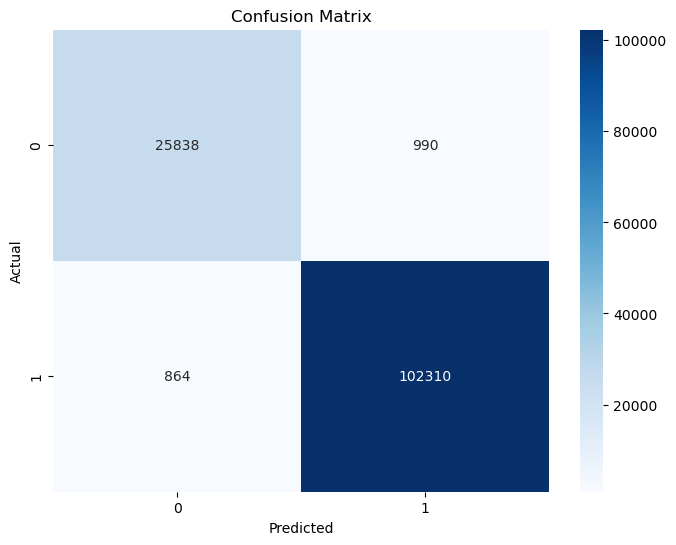


ROC-AUC Score: 0.9944017430226659


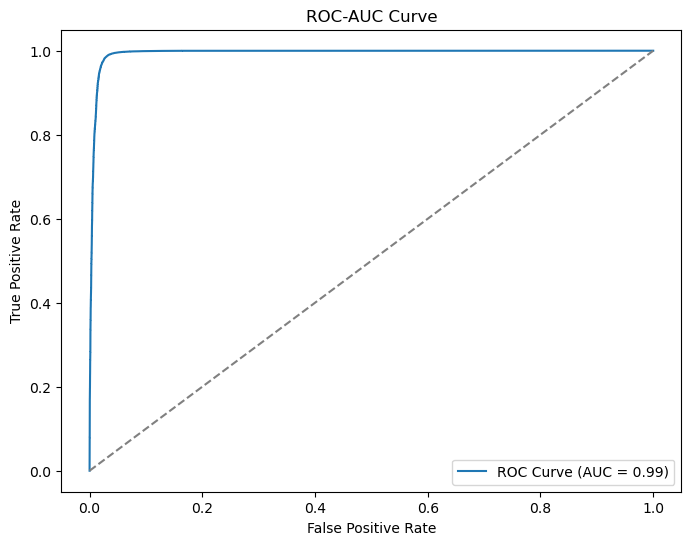

In [ ]:
from sklearn.metrics import (
    accuracy_score, 
    classification_report, 
    roc_auc_score, 
    roc_curve, 
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier


# Initialize XGBClassifier
xgb = XGBClassifier(
    n_estimators=100, 
    max_depth=10, 
    n_jobs=-1, 
    use_label_encoder=False, 
    eval_metric='logloss', 
    random_state=42
)

# Train the model
xgb.fit(X_resampled_pca, y_resampled)

# Predict on test set
y_pred = xgb.predict(X_test_pca)
y_pred_proba = xgb.predict_proba(X_test_pca)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC-AUC Curve
if len(np.unique(y)) == 2:  # For binary classification
    auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
    print("\nROC-AUC Score:", auc_score)
    
    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curve")
    plt.legend()
    plt.show()
else:
    print("\nROC-AUC Curve is not applicable for multi-class classification.")

In [11]:
# Save the trained model as a pickle file
with open("portfolio project/pickle_data/xgb_model.pkl", "wb") as file:
    pickle.dump(xgb, file)